# Oscilloscope forced trigger

This example shows how a signal can be captured using a forced trigger.

**Note:**  
Voltage range of fast analog inputs on the Red Pitaya depends on gain setting that can be set by jumpers. HV setting is for input range to ±20V, while LV sets input range to ±1V. For more information please read the following [chapter](http://redpitaya.readthedocs.io/en/latest/doc/developerGuide/125-14/fastIO.html#analog-inputs). 

Create a loop back from fast outputs to the fast inputs as shown in the picture below.  
Make sure that *gain setting* is set to ±1V (LV).

![Fast loop back](img/FastIOLoopBack.png "Example of the fast loop back.")

Now start generation of the signal from the [generator notebook](gen_sync_two_channel.ipynb). Execute all cells except the last one which will disable the outputs. It is recommended that you run it when you finish with this example.

In [1]:
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()

Requested overlay is already loaded.


Make an instance of the oscilloscope, the first argument is the channel index in range [0,1]. The second argument is the voltage range in volts, should be either 1.0 (default if unspecified) or 20.0.

In [2]:
osc0 = fpga.osc(1, 1.0)

User should specify:
1. Sample rate decimation is an integer in range [1, 2\*\*17] = [1, 131072].
2. Number of samples stored before and after trigger, for a forced trigger only post trigger samples are enough.
3. Input level trigger source should (depending on the test purpose) be disabled (it is enabled by default)

In [3]:
# data rate decimation 
osc0.decimation = 8000

# trigger timing [sample periods]
N = osc0.buffer_size
osc0.trigger_pre  = 0
osc0.trigger_post = N

# disable hardware trigger sources
osc0.trig_src = 0

The oscilloscope should be reset, started, and a software trigger should be issued.
A loop is checking if the desired number of data samples was already stored in the buffer.

The same number of samples as the sum of pre/post trigger delays should be read from the buffer.
The data read is aligned to the last sample, which will be always present as the last sample in the returned array.

triggered


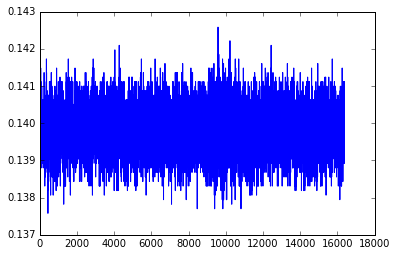

In [15]:
# synchronization and trigger sources are the default,
# which is the module itself
osc0.reset()
osc0.start()
osc0.trigger()
# wait for data
while (osc0.status_run()): pass
print ('triggered')

import matplotlib.pyplot as plt

# show only the part of the buffer requested by pre/post trigger timing
data = osc0.data(N)
plt.plot(data)
plt.show()

In [16]:
data

array([ 0.1396527 ,  0.1396527 ,  0.1396527 , ...,  0.13989684,
        0.14050722,  0.13977477], dtype=float32)

In [ ]:
import IPython.display as ipd
sr = 18050 # sample rate
ipd.Audio(data, rate=sr) # load a NumPy array

In [ ]:
import librosa.display

In [ ]:
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [5]:
chn = 4
channels = [fpga.analog_in(ch) for ch in range(chn)]

In [18]:
import numpy as np
buffer = np.zeros( 10, dtype=np.int16 )
for i in buffer:
    print(i)

0
0
0
0
0
0
0
0
0
0


In [14]:
T = 0.01 # sampling period
x=[]
y=[ [], [], [], [] ]

# take 20000 samples while simultaneously plotting the plot
for i in range(20):
    buffer.append(channels[0].read())
    
#    time.sleep(T)

AttributeError: 'numpy.dtype' object has no attribute 'append'

In [ ]:


adc = pyb.ADC('X1')
buf = array.array('H', bytearray(20000))
timerADC = pyb.Timer(4, freq=2000000) 
t1=pyb.micros(); n=adc.read_timed(buf,timerADC); t2=pyb.micros()
print("20000 ADC readings done after %u us." %(t2-t1))
print("Mean time for each ADC reading = %15.13f us" % ((t2-t1)/20000.0))
print("ADC reading = %15.13f ksamples/s" % (1000/((t2-t1)/20000.0)))